# Continuous Variable VQE for long-range molecular interactions

In the following, we illustrate how our code can be used to study the system composed of a pair of QDO oscillators. We focus on a 1-dimensional model for efficiency, but the code generalized to the full-fledged 3d QDO model.

We focus on the case of a diatomic system.

## Imports

In [1]:
from argparse import ArgumentParser
from datetime import datetime
from dataclasses import dataclass
import json
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('./src/plots.mplstyle')
from matplotlib import cm
import numpy as np
import os
import strawberryfields as sf
from strawberryfields.backends.tfbackend.states import FockStateTF
import tensorflow as tf

from src.energy_surface import EnergySurface
from src.utils import Atom
from src.constants import *

2023-02-09 13:52:17.397021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 13:52:17.528404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-09 13:52:17.528425: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-09 13:52:18.225624: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

Let us define the following `Atom` dataclass to store the QDO parameters later

In [3]:
@dataclass
class Atom:
    m: float
    omega: float
    q: float

You can choose among the following list of atoms. Note that the 'Un' atom corresponds to a fictitious atom with unit parameters.

In [4]:
ATOMIC_PARAMETERS = {
    'Un': {'omega': 1.0000, 'm': 1.0000, 'q': 1.0000},
    'H':  {'omega': 0.4280, 'm': 0.8348, 'q': 0.8295},
    'Ne': {'omega': 1.1933, 'm': 0.3675, 'q': 1.1820},
    'Ar': {'omega': 0.6958, 'm': 0.3562, 'q': 1.3835},
    'Kr': {'omega': 0.6122, 'm': 0.3401, 'q': 1.4635},
    'Xe': {'omega': 0.5115, 'm': 0.3298, 'q': 1.5348},
}

## Preliminaries: defining the inputs of the simulation

Let us first define the various parameters relevant for the definition and the training of the model

In [5]:
args = {
    'layers': 8,
    'cutoff_dim': 5,
    'model': '20',
    'atom_list': ['Un', 'Un'],
    'active_sd': 0.0001,
    'passive_sd': 0.1,
    'learning_rate': 0.01,
    'epsilon': 1e-3,
    'patience': 30,
    'seed': 42,
    'save_dir': './logs/'
}

args['dimension'] = 3 if args['model'][1]=='3' else 1
args['modes'] = len(args['atom_list']) * args['dimension']

args = objectview(args)

By default, Strawberry Fields sets $\hbar=2$. Let us redefine it to fit atomic units conventions

In [6]:
sf.hbar = 1.0

Let us also set the random seeds for reproducibility of the results

In [7]:
tf.random.set_seed(args.seed)
np.random.seed(args.seed)

Let us define a directory where to store the results of the simulation

Let us store the QDO's data into dataclass

In [8]:
atoms = []

for atom in args.atom_list:

    atoms.append(Atom(
        m=ATOMIC_PARAMETERS[atom]['m'],
        omega=ATOMIC_PARAMETERS[atom]['omega'],
        q=ATOMIC_PARAMETERS[atom]['q']
    ))

We work with the quadratures of the electromagnetic field, which are real valued variables, hence need to be discretized

In [9]:
x_quadrature_grid = np.linspace(-7.0, 7.0, 200)

Let us finally specify a list of interatomic distances, used to define the binding energy curve of the system of two QDOs

In [10]:
distances = list(np.linspace(0.1, 3.5, 70))

## Training

We are finally ready to instanciate a `EnergySurface` object, whose ability is to run a VQE algorithm for each of the specified interatomic distances, and store the results in the simulation in the directory defined previously.

In [11]:
save_dir = os.path.join(
    args.save_dir,
    'model={}'.format(args.model),
    datetime.now().strftime("%Y.%m.%d.%H.%M.%S")
)

energy_surface = EnergySurface(
    layers=args.layers,
    distance_list=distances,
    model=args.model,
    x_quadrature_grid=x_quadrature_grid,
    atoms=atoms,
    active_sd=args.active_sd,
    passive_sd=args.passive_sd,
    cutoff_dim=args.cutoff_dim,
    learning_rate=args.learning_rate,
    save_dir=save_dir,
    verbose=True
)

In [12]:
energy_surface.construct_energy_surface(
    epsilon=args.epsilon,
    patience=args.patience
)

Distance 1/70


2023-02-09 13:20:15.216519: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-09 13:20:15.216546: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-09 13:20:15.216561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (uni-OptiPlex-7480-AIO): /proc/driver/nvidia/version does not exist
2023-02-09 13:20:15.216824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Distance 2/70
Epoch 009 | Loss 1571.697967
Distance 3/70
Distance 4/70
Distance 5/70
Distance 6/70
Epoch 009 | Loss 48.416328
Distance 7/70
Distance 8/70
Epoch 009 | Loss 1.929539
Distance 9/70
Epoch 009 | Loss -8.990741
Distance 10/70
Epoch 009 | Loss -13.756041
Distance 11/70
Epoch 009 | Loss 1.540113
Epoch 019 | Loss -82.630739
Distance 12/70
Epoch 009 | Loss 3.407353
Epoch 019 | Loss -20.688962
Distance 13/70
Epoch 009 | Loss -28.143339
Distance 14/70
Epoch 009 | Loss -27.144723
Epoch 019 | Loss -98.356376
Distance 15/70
Epoch 009 | Loss -6.836303
Epoch 019 | Loss -72.049165
Distance 16/70
Epoch 009 | Loss 1.480900
Epoch 019 | Loss -8.007142
Epoch 029 | Loss -67.179979
Epoch 039 | Loss -86.683393
Epoch 049 | Loss -96.747242
Epoch 059 | Loss -99.147394
Distance 17/70
Epoch 009 | Loss -8.805266
Epoch 019 | Loss -44.605555
Epoch 029 | Loss -64.916930
Epoch 039 | Loss -74.803118
Epoch 049 | Loss -77.496506
Epoch 059 | Loss -78.519462
Epoch 069 | Loss -79.318130
Epoch 079 | Loss -80.116

## Plotting the binding curve

In [32]:
distance_array = np.load('logs/model=20/2023.02.09.13.20.15/energy_surface/distance_list.npy')
binding_energy_array = np.load('logs/model=20/2023.02.09.13.20.15/energy_surface/energy_surface.npy')
start=34

In [33]:
distance_array[start:].astype('float32').tofile('./mathematica/x3.dat')
binding_energy_array[start:].astype('float32').tofile('./mathematica/y3.dat')

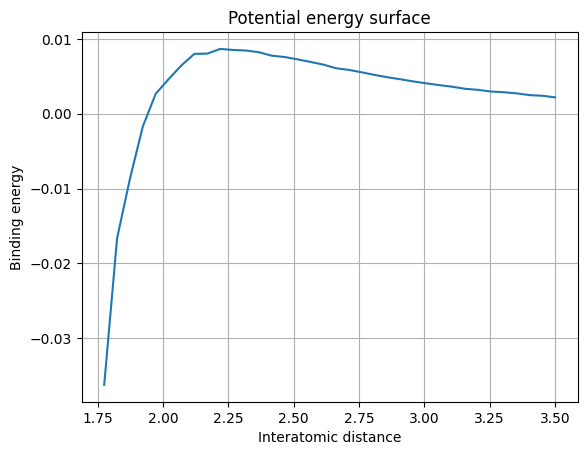

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=1)
#axes.scatter(distance_array[4:], binding_energy_array[4:], s=10)
axes.plot(distance_array[start:], binding_energy_array[start:])
axes.set_xlabel('Interatomic distance')
axes.set_ylabel('Binding energy')
axes.grid(True)
axes.set_title('Potential energy surface')
plt.show()
#plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

## Wigner functions vizualization

In [ ]:
import glob

directory = 'logs/model=30/2023.02.08.16.41.09'
fig_dir = os.path.join(directory, 'figures')
os.makedirs(fig_dir, exist_ok=True)

X, P = np.meshgrid(x_quadrature_grid, x_quadrature_grid)

states = glob.glob(os.path.join(directory, 'states/state_d=*'))
states.sort()
states = states[0:]

for file in states:
    
    distance = file.split('=')[2].split('.npy')[0]
    state_data = np.load(file)
    state = FockStateTF(state_data=state_data, num_modes=args.modes, pure=True, cutoff_dim=args.cutoff_dim)

    w_qdo1 = state.wigner(mode=0, xvec=x_quadrature_grid, pvec=x_quadrature_grid)
    w_qdo2 = state.wigner(mode=1, xvec=x_quadrature_grid, pvec=x_quadrature_grid)

    fig = plt.figure(figsize=(11, 8))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(X, P, w_qdo1, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
    ax1.set_axis_off()
    ax1.set_title("QDO 1")
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(X, P, w_qdo1, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
    ax2.set_axis_off()
    ax2.set_title("QDO 2")
    plt.savefig(os.path.join(fig_dir, distance + '.png'))
    plt.close()

## Marginal densities vizualization

In [57]:
plt.style.use('src/plots.mplstyle')

In [58]:
import glob

directory = 'logs/model=30/2023.02.08.16.41.09'
fig_dir = os.path.join(directory, 'figures')
os.makedirs(fig_dir, exist_ok=True)

states = glob.glob(os.path.join(directory, 'quad_marginals/marginals_d=*'))
states.sort()
states = states[start:]

for file in states:
    
    distance = file.split('=')[2].split('.npy')[0]
    data = np.load(file)
    state = FockStateTF(state_data=state_data, num_modes=args.modes, pure=True, cutoff_dim=args.cutoff_dim)

    rho1 = data[0]
    rho2 = data[1]

    fig = plt.figure(figsize=(11, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_quadrature_grid, rho1)
    ax.plot(x_quadrature_grid, rho2)
    ax.set_xlabel('Position relative to QDO center')
    ax.set_title("Marginal position quadrature densities")
    plt.yticks([])
    plt.savefig(os.path.join(fig_dir, distance + '.png'))
    plt.close()

: 

: 

## Joint density vizualization

In [ ]:
import glob

directory = 'logs/model=30/2023.02.08.16.41.09'
fig_dir = os.path.join(directory, 'figures')
os.makedirs(fig_dir, exist_ok=True)

X1, X2 = np.meshgrid(x_quadrature_grid, x_quadrature_grid)

states = glob.glob(os.path.join(directory, 'quad_density/density_d=*'))
states.sort()
states = states[start:]

for file in states:
    
    distance = file.split('=')[2].split('.npy')[0]
    joint_density = np.load(file)

    fig = plt.figure(figsize=(11, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    ax1.plot_surface(X1, X2, joint_density, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
    ax1.set_axis_off()
    ax1.set_title("Position quadratures joint density")
    plt.savefig(os.path.join(fig_dir, distance + '.png'))
    plt.close()